In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lmfit import Model
import datetime


In [35]:
# load data
file = 'D:/O2_Calibration_Images/RAW_2023-08-14/red_green_ratio.csv'
data = pd.read_csv(file, decimal=',')
print(data)


    Temperature/O2  Intensity Ratio  Intensity Red  Intensity Green  \
0              0.0         1.884761    2318.925648      1229.530458   
1              9.5         1.678027    1905.795801      1135.056447   
2             19.3         1.529194    1647.519776      1076.834242   
3             29.6         1.418740    1471.228756      1036.517262   
4             39.9         1.335173    1346.660882      1008.214512   
5             49.5         1.272070    1257.549034       988.235101   
6             60.3         1.215613    1183.009586       972.897383   
7             70.7         1.167192    1119.838224       959.183781   
8             80.2         1.129882    1067.751984       944.819785   
9             90.0         1.096283    1025.948318       935.688683   
10           100.0         1.057531     981.896512       928.367288   
11             0.0         1.885259    2322.420218      1231.054511   
12             9.5         1.675959    1909.369954      1138.596523   
13    

In [36]:
# Group the data by Air Saturation and calculate the mean ratio for each air saturation value
grouped_data = data.groupby('Temperature/O2').mean().round(4)
print(grouped_data)

# Get the R0 value: Intensity Ratio at Air Saturation = 0%
R0 = data.iloc[0, 1]
print('this is R0', R0)

# Normalize the data by R0/R
grouped_data['Intensity Ratio'] = R0 / grouped_data['Intensity Ratio']  
print(grouped_data)


                Intensity Ratio  Intensity Red  Intensity Green  \
Temperature/O2                                                    
0.0                      1.8853      2322.1116        1230.8556   
9.5                      1.6761      1907.2694        1137.2878   
19.3                     1.5294      1652.8306        1080.1805   
29.6                     1.4183      1474.8494        1039.3570   
39.9                     1.3340      1348.4537        1010.4553   
49.5                     1.2720      1260.8593         990.8478   
60.3                     1.2139      1181.7451         973.2453   
70.7                     1.1665      1119.8564         959.7988   
80.2                     1.1293      1068.9790         946.3917   
90.0                     1.0960      1026.1668         936.1221   
100.0                    1.0576       982.9468         929.3367   

                Intensity Blue  Std Ratio   Std Red  Std Green  Std Blue  
Temperature/O2                                       

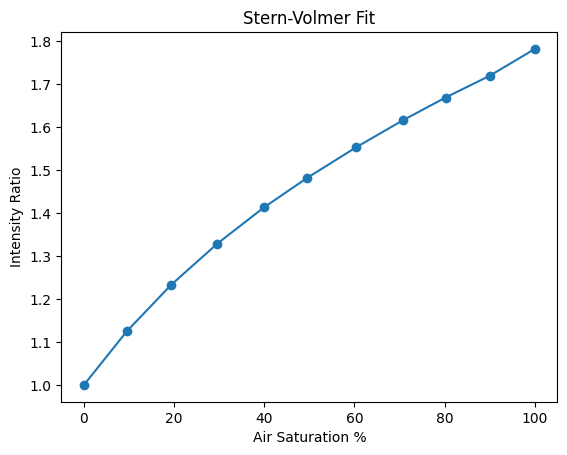

In [37]:
# Create a plot
plt.plot(grouped_data.index, grouped_data['Intensity Ratio'], 'o-')

# Set the x-axis and y-axis labels
plt.title('Stern-Volmer Fit')
plt.xlabel('Air Saturation %')
plt.ylabel('Intensity Ratio')
plt.show()

In [38]:
# define simplified Stern-Volmer function
def _sternvolmer_simple(x, f, k):
    """
    fitting function according to the common two site model. In general, x represents the pO2 or pCO2 content, whereas
    m, k and f are the common fitting parameters
    :param x:   list
    :param k:   np.float
    :param f:   np.float
    :return:
    """
    # R0/R
    int_ratio = 1 / (f / (1. + k*x) + (1.-f))
    return int_ratio

# make your function a model to be used by lmfit
simple_sv = Model(_sternvolmer_simple)

In [39]:
# set initial parameter
params_sens = simple_sv.make_params(k=0.165, f=0.887) # from previous calibrations approximately known
params_sens['k'].min = 0.
params_sens['f'].max = 1.

# use R0/R data for fit and re-calculate i afterwards
# full concentration range
ytofit_sens = grouped_data['Intensity Ratio'].to_numpy()
xtofit_sens = grouped_data.index.to_numpy() 
result = simple_sv.fit(ytofit_sens, params_sens, x=xtofit_sens, nan_policy='omit')

[[Model]]
    Model(_sternvolmer_simple)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 11
    # variables        = 1
    chi-square         = 3.5676e-04
    reduced chi-square = 3.5676e-05
    Akaike info crit   = -111.699691
    Bayesian info crit = -111.301796
    R-squared          = 0.99944432
[[Variables]]
    f:  0.64462573 +/- 0.00139812 (0.22%) (init = 0.6446257)
    k:  0.02073065 (fixed)


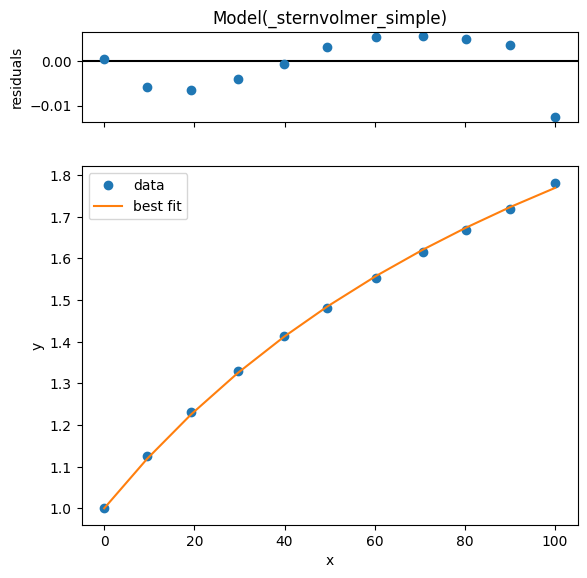

In [40]:
# to optimize the fit (and be sure of the parameter) >> 2nd round with one parameter fixed
params_sens2 = params_sens.copy()
params_sens2['k'].value = result.best_values['k']
params_sens2['k'].vary = False
params_sens2['f'].value = result.best_values['f']

params_sens2['f'].min = 0.
params_sens2['f'].max = 1.
result2 = simple_sv.fit(ytofit_sens, params_sens2, x=xtofit_sens, nan_policy='omit')

df_bestFit_preSens_norm = pd.DataFrame(1 / result2.best_fit, index=xtofit_sens)
df_bestFit_preSens = pd.DataFrame(grouped_data.loc[0, 'Intensity Ratio'] / result2.best_fit, index=xtofit_sens)
result2.best_values
fit_report = result2.fit_report()
print(fit_report)
result2.plot()
plt.show()



In [ ]:
# SAVE THE RESULT
# best fit for parameter done... save report
import datetime

now = datetime.datetime.now()
time_now = now.strftime('%Y%m%d-%H%M%S')

# save fit report to a file
with open('C:/Users/au519867/OneDrive - Aarhus universitet/Skrivebord/Raw_Images/RAW_Stacks/Intensity_Ratio/' + time_now + '_fit_result.txt', 'w') as fh:
    fh.write(fit_report)
